In [1]:
import numpy as np
import nibabel as nib

In [2]:
img = nib.load("/Users/pikachu/Desktop/NDD/data/sub-NDARDN702GXX/sub-NDARDN702GXX_task-rest_bold.nii.gz")
data = img.get_data()
data = data[:,:,:,int(data.shape[-1]/2)]

In [3]:
from dipy.segment.mask import median_otsu
# b0_mask, mask = median_otsu(data , 3, 2)

In [4]:
import matplotlib.pyplot as plt
from dipy.core.histeq import histeq

In [5]:
# viz slices in the transversal plane
transversal = np.transpose(data, [1, 0, 2])
# transversal = np.rot90(transversal, 2)
transversal.shape

b0_mask, mask = median_otsu(transversal , 3, 2)

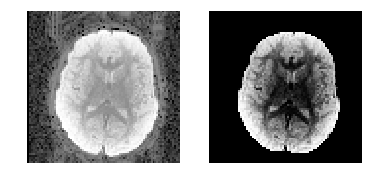

In [6]:
sli = transversal.shape[2] // 2
plt.figure('Brain segmentation')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(histeq(transversal[:, :, sli].astype('float')),
           cmap='gray', origin='lower')

plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(histeq(b0_mask[:, :, sli].astype('float')),
           cmap='gray', origin='lower')

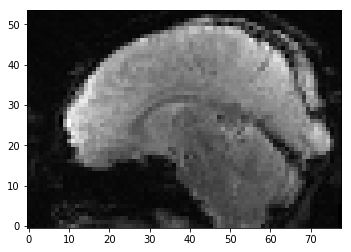

In [7]:
# viz slices in the sagittal plane
sagittal = np.transpose(data, [1, 2, 0])
sagittal = np.rot90(sagittal, 3)
sagittal.shape

sli = sagittal.shape[2] // 2
plt.imshow(sagittal[:,:,sli], cmap='gray', origin='lower')

b0_mask, mask = median_otsu(sagittal , 3, 2)

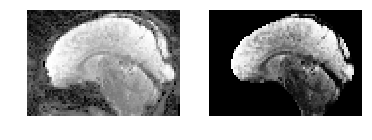

In [8]:

plt.figure('Brain segmentation')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(histeq(sagittal[:, :, sli].astype('float')),
           cmap='gray', origin='lower')

plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(histeq(b0_mask[:, :, sli].astype('float')),
           cmap='gray', origin='lower')

In [10]:
from __future__ import division, print_function
import nibabel as nib
import numpy as np
from dipy.segment.mask import median_otsu

from dipy.io.image import load_nifti, save_nifti
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.reconst.dti import TensorModel

fdwi = "/Users/pikachu/Desktop/NDD/data/sub-NDARBN100LCD/dwi/sub-NDARBN100LCD_acq-64dir_dwi.nii.gz"
fbval = "/Users/pikachu/Desktop/NDD/data/sub-NDARBN100LCD/dwi/sub-NDARBN100LCD_acq-64dir_dwi.bval"
fbvec = "/Users/pikachu/Desktop/NDD/data/sub-NDARBN100LCD/dwi/sub-NDARBN100LCD_acq-64dir_dwi.bvec"

data, affine = load_nifti(fdwi)
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs)

tenmodel = TensorModel(gtab)
tenfit = tenmodel.fit(data)

affine = img.affine

print('Computing brain mask...')
b0_mask, mask = median_otsu(data)

print('Computing tensors...')
tenmodel = TensorModel(gtab)
tensorfit = tenmodel.fit(data, mask=mask)

Computing brain mask...
Computing tensors...


(96, 96, 72, 129)


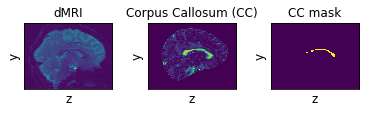

In [23]:
# print('Computing worst-case/best-case SNR using the corpus callosum...')
from dipy.segment.mask import segment_from_cfa
from dipy.segment.mask import bounding_box

print(data.shape)

threshold = (0.6, 1, 0, 0.1, 0, 0.1)
CC_box = np.zeros_like(data[..., 0])

mins, maxs = bounding_box(mask)
mins = np.array(mins)
maxs = np.array(maxs)
diff = (maxs - mins) // 4
bounds_min = mins + diff
bounds_max = maxs - diff

CC_box[bounds_min[0]:bounds_max[0],
       bounds_min[1]:bounds_max[1],
       bounds_min[2]:bounds_max[2]] = 1

mask_cc_part, cfa = segment_from_cfa(tensorfit, CC_box, threshold,
    return_cfa=True)

cfa_img = nib.Nifti1Image((cfa*255).astype(np.uint8), affine)
mask_cc_part_img = nib.Nifti1Image(mask_cc_part.astype(np.uint8), affine)
# nib.save(mask_cc_part_img, 'mask_CC_part.nii.gz')

import matplotlib.pyplot as plt
region = 48
fig = plt.figure('Corpus callosum segmentation')

plt.subplot(1, 3, 1)
plt.title("dMRI")
# plt.axis('off')
plt.xlabel('z', size = 12)
plt.ylabel('y', size = 12)
plt.xticks([])
plt.yticks([])
red = cfa[..., 0]
plt.imshow(np.rot90(data[48, :, :, 0]))

plt.subplot(1, 3, 2)
plt.title("Corpus Callosum (CC)")
# plt.axis('off')
plt.xlabel('z', size = 12)
plt.ylabel('y', size = 12)
plt.xticks([])
plt.yticks([])
red = cfa[..., 0]
plt.imshow(np.rot90(red[region, ...]))

plt.subplot(1, 3, 3)
plt.title("CC mask")
# plt.axis('off')
plt.xlabel('z', size = 12)
plt.ylabel('y', size = 12)
plt.xticks([])
plt.yticks([])
fig.subplots_adjust(wspace=0.4)

plt.imshow(np.rot90(mask_cc_part[region, ...]))

fig.savefig("CC_segmentation.png", bbox_inches='tight')